# **RECOMPRA EM E-COMMERCE: FLORESTA ALEATÓRIA**



### Instalação de bibliotecas

In [ ]:
# Apenas a biblioteca shap precisa ser instalada; as demais utilizadas neste notebook já vêm pré-instaladas no Google Colab
! pip install shap

### Carregamento de bibliotecas

In [ ]:
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import ensemble                                   # Floresta aleatória
from sklearn.model_selection import KFold, cross_validate      # Validação cruzada
from sklearn.model_selection import GridSearchCV               # Otimização de hiperparâmetros via grid search
from sklearn.model_selection import RandomizedSearchCV         # Otimização de hiperparâmetros via random search
import shap                                                    # Interpretabilidade de modelos de ML

### Leitura da base de dados

In [ ]:
dados_ecommerce = pd.read_table("Recompra_eCommerce.txt", sep = "\t")

### Visualização da base de dados

In [ ]:
display(dados_ecommerce)

,ID_CLIENTE,IDADE,VALOR_COMPRA_SITE,QTDE_ITENS_COMPRA_SITE,FLAG_ACESSORIOS_COMPRA_SITE,FLAG_FEMININA_COMPRA_SITE,FLAG_MASCULINA_COMPRA_SITE,NOTA_SATISF_COMPRA_SITE,FLAG_COMPROU_LOJA_FISICA_6M,QTDE_COMPRAS_LOJA_FISICA_6M,QTDE_ITENS_LOJA_FISICA_6M,FLAG_RECOMPRA_PROX_3_MESES
0,1,29,185.5,2,0,1,0,7,1,4,4,1
1,2,27,215.5,2,0,1,1,7,1,2,2,1
2,3,29,106.4,4,0,1,0,10,1,1,5,1
3,4,18,140.2,1,0,1,0,8,1,1,4,0
4,5,24,72.9,2,0,1,0,7,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1269,1270,40,165.9,6,0,1,0,8,1,3,9,1
1270,1271,33,55.6,1,0,1,0,9,0,0,0,0
1271,1272,28,105.7,4,0,0,1,6,0,0,0,0
1272,1273,28,284.9,3,0,1,1,8,0,0,0,0


### Separação de features e target

In [ ]:
X = dados_ecommerce.drop(columns = ['FLAG_RECOMPRA_PROX_3_MESES', 'ID_CLIENTE'])
y = dados_ecommerce['FLAG_RECOMPRA_PROX_3_MESES']

### Criação de colunas dummy para variáveis explicativas qualitativas

In [ ]:
# Não necessário para esta base de dados, pois todas as variáveis explicativas são quantitativas

### Modelo 1: floresta aleatória com otimização de hiperparâmetros via validação cruzada, com grid search

In [ ]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
    'min_samples_leaf': [10, 20, 50, 100],
    'max_depth': [2, 3, 5, 10]
}

In [ ]:
# Busca da melhor combinação de hiperparâmetros, via validação cruzada com grid search, com otimização de AUC e k = 10 (EXECUÇÃO ONEROSA)
floresta = ensemble.RandomForestClassifier(random_state = 123)
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)
scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
grid_search = GridSearchCV(floresta, param_grid, cv = cv, scoring = scoring, refit = 'AUC')
grid_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=RandomForestClassifier(random_state=123),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10],
                         'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
                         'min_samples_leaf': [10, 20, 50, 100],
                         'n_estimators': [10, 50, 100, 200]},
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'balanced_accuracy': 'balanced_accuracy',
                      'recall': 'recall'})

In [ ]:
# Melhor configuração de hiperparâmetros identificada
print(grid_search.best_params_)

{'criterion': 'gini', 'max_depth': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'n_estimators': 100}


In [ ]:
# Tabela de desempenho com todas as combinações de hiperparâmetros testadas, ordenadas do maior para o menor AUC médio nos conjuntos de teste
resultados_grid = pd.DataFrame(grid_search.cv_results_)
resultados_grid = resultados_grid[['params',
                                   'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC',
                                   'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy',
                                   'mean_test_recall', 'std_test_recall', 'rank_test_recall']].sort_values(by = 'rank_test_AUC')
resultados_grid

,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy,mean_test_recall,std_test_recall,rank_test_recall
194,"{'criterion': 'gini', 'max_depth': 10, 'min_im...",0.905037,0.019479,1,0.827900,0.028438,16,0.866433,0.042857,69
451,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.904926,0.020610,2,0.825922,0.028762,38,0.863816,0.041115,77
450,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.904717,0.019499,3,0.826156,0.027268,34,0.864061,0.036662,76
193,"{'criterion': 'gini', 'max_depth': 10, 'min_im...",0.904673,0.022139,4,0.829809,0.032436,6,0.866255,0.045270,72
387,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.904592,0.019354,5,0.827039,0.028977,29,0.869724,0.039608,53
...,...,...,...,...,...,...,...,...,...,...
49,"{'criterion': 'gini', 'max_depth': 2, 'min_imp...",0.850801,0.019363,497,0.763699,0.023331,317,0.775752,0.029751,365
57,"{'criterion': 'gini', 'max_depth': 2, 'min_imp...",0.850801,0.019363,497,0.763699,0.023331,317,0.775752,0.029751,365
189,"{'criterion': 'gini', 'max_depth': 5, 'min_imp...",0.850801,0.019363,497,0.763699,0.023331,317,0.775752,0.029751,365
245,"{'criterion': 'gini', 'max_depth': 10, 'min_im...",0.850801,0.019363,497,0.763699,0.023331,317,0.775752,0.029751,365


In [ ]:
# Modelo final a partir da melhor combinação de hiperparâmetros
floresta_1 = grid_search.best_estimator_

### Modelo 2: floresta aleatória com otimização de hiperparâmetros via validação cruzada, com random search

In [ ]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': np.arange(10, 201, 10),
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': np.arange(0, 0.11, 0.01),
    'min_samples_leaf': np.arange(10, 101),
    'max_depth': np.arange(2, 11)
}

In [ ]:
# Busca da melhor combinação de hiperparâmetros, via validação cruzada com random search, com otimização de AUC e k = 10
floresta = ensemble.RandomForestClassifier(random_state = 123)
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)
scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
random_search = RandomizedSearchCV(floresta, param_grid, cv = cv, scoring = scoring, refit = 'AUC', n_iter = 100, random_state = 123)
random_search.fit(X, y)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=RandomForestClassifier(random_state=123),
                   n_iter=100,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'min_impurity_decrease': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                                        'min_samples_leaf': array([ 10,  11,  12,  13,  14...
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])},
                   random_state=123, refit='AUC',
                   scoring={'AUC': 'roc_auc',
                            'balanced_accuracy': 'balanced_accuracy',
                            'recall': 'recall'})

In [ ]:
# Melhor configuração de hiperparâmetros identificada
print(random_search.best_params_)

{'n_estimators': 150, 'min_samples_leaf': 17, 'min_impurity_decrease': 0.0, 'max_depth': 4, 'criterion': 'entropy'}


In [ ]:
# Tabela de desempenho com todas as combinações de hiperparâmetros testadas, ordenadas do maior para o menor AUC médio nos conjuntos de teste
resultados_grid = pd.DataFrame(random_search.cv_results_)
resultados_grid = resultados_grid[['params',
                                   'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC',
                                   'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy',
                                   'mean_test_recall', 'std_test_recall', 'rank_test_recall']].sort_values(by = 'rank_test_AUC')
resultados_grid

,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy,mean_test_recall,std_test_recall,rank_test_recall
9,"{'n_estimators': 150, 'min_samples_leaf': 17, ...",0.902754,0.019790,1,0.826937,0.028042,3,0.862564,0.030603,6
92,"{'n_estimators': 110, 'min_samples_leaf': 28, ...",0.899814,0.022066,2,0.826455,0.029249,4,0.868124,0.040580,3
48,"{'n_estimators': 30, 'min_samples_leaf': 37, '...",0.898966,0.020969,3,0.828028,0.026886,1,0.865214,0.039846,5
98,"{'n_estimators': 20, 'min_samples_leaf': 21, '...",0.898132,0.022077,4,0.827968,0.027851,2,0.866407,0.043735,4
42,"{'n_estimators': 160, 'min_samples_leaf': 26, ...",0.896805,0.021417,5,0.820351,0.027993,6,0.844807,0.039104,11
...,...,...,...,...,...,...,...,...,...,...
3,"{'n_estimators': 110, 'min_samples_leaf': 77, ...",0.851431,0.019417,96,0.763699,0.023331,65,0.775752,0.029751,68
40,"{'n_estimators': 60, 'min_samples_leaf': 43, '...",0.851400,0.020140,97,0.763699,0.023331,65,0.775752,0.029751,68
44,"{'n_estimators': 60, 'min_samples_leaf': 53, '...",0.851400,0.020140,97,0.763699,0.023331,65,0.775752,0.029751,68
45,"{'n_estimators': 80, 'min_samples_leaf': 76, '...",0.851228,0.019447,99,0.760638,0.026298,98,0.775752,0.029751,68


In [ ]:
# Modelo final a partir da melhor combinação de hiperparâmetros
floresta_2 = random_search.best_estimator_

### Estimativa de desempenho do modelo 1 em dados totalmente apartados, via validação cruzada aninhada

In [ ]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
    'min_samples_leaf': [10, 20, 50, 100],
    'max_depth': [2, 3, 5, 10]
}

In [ ]:
# Validação cruzada aninhada com grid search e otimização de AUC, k1 = 3 e k2 = 5 (EXECUÇÃO ONEROSA)
floresta = ensemble.RandomForestClassifier(random_state = 123)
inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
grid_search = GridSearchCV(floresta, param_grid, cv = inner_cv, scoring = scoring, refit = 'AUC')
nested_scores = cross_validate(grid_search, X = X, y = y, cv = outer_cv, scoring = scoring)

In [ ]:
# AUC das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_AUC'].round(3))
print("Média de AUC: " + str(round(np.mean(nested_scores['test_AUC']), 3)))
print("D.P. de AUC: " + str(round(np.std(nested_scores['test_AUC']), 3)))

[0.882 0.9   0.914 0.903 0.921]
Média de AUC: 0.904
D.P. de AUC: 0.013


In [ ]:
# Acurácia balanceada das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_balanced_accuracy'].round(3))
print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))

[0.803 0.808 0.846 0.836 0.85 ]
Média de Acurácia Balanceada: 0.829
D.P. de Acurácia Balanceada: 0.019


In [ ]:
# Sensibilidade das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_recall'].round(3))
print("Média de Sensibilidade: " + str(round(np.mean(nested_scores['test_recall']), 3)))
print("D.P. de Sensibilidade: " + str(round(np.std(nested_scores['test_recall']), 3)))

[0.831 0.879 0.861 0.896 0.891]
Média de Sensibilidade: 0.872
D.P. de Sensibilidade: 0.024


### Estimativa de desempenho do modelo 2 em dados totalmente apartados, via validação cruzada aninhada

In [ ]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': np.arange(10, 201, 10),
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': np.arange(0, 0.11, 0.01),
    'min_samples_leaf': np.arange(10, 101),
    'max_depth': np.arange(2, 11)
}

In [ ]:
# Validação cruzada aninhada com random search e otimização de AUC, k1 = 3 e k2 = 5
floresta = ensemble.RandomForestClassifier(random_state = 123)
inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
random_search = RandomizedSearchCV(floresta, param_grid, cv = inner_cv, scoring = scoring, refit = 'AUC', n_iter = 100, random_state = 123)
nested_scores = cross_validate(random_search, X = X, y = y, cv = outer_cv, scoring = scoring)

In [ ]:
# AUC das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_AUC'].round(3))
print("Média de AUC: " + str(round(np.mean(nested_scores['test_AUC']), 3)))
print("D.P. de AUC: " + str(round(np.std(nested_scores['test_AUC']), 3)))

[0.878 0.898 0.911 0.9   0.921]
Média de AUC: 0.901
D.P. de AUC: 0.014


In [ ]:
# Acurácia balanceada das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_balanced_accuracy'].round(3))
print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))

[0.8   0.813 0.838 0.84  0.846]
Média de Acurácia Balanceada: 0.827
D.P. de Acurácia Balanceada: 0.018


In [ ]:
# Sensibilidade das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_recall'].round(3))
print("Média de Sensibilidade: " + str(round(np.mean(nested_scores['test_recall']), 3)))
print("D.P. de Sensibilidade: " + str(round(np.std(nested_scores['test_recall']), 3)))

[0.823 0.872 0.854 0.896 0.875]
Média de Sensibilidade: 0.864
D.P. de Sensibilidade: 0.025


### Aplicação do modelo final de floresta aleatória na base de dados



In [ ]:
# Aplicação do modelo (cálculo das probabilidades preditas)
y_prob = floresta_1.predict_proba(X)[:,1]

In [ ]:
# Definição de ponto de corte
ponto_corte = y.astype(int).mean()

In [ ]:
# Atribuição da categoria predita
dados_ecommerce['y_pred'] = (y_prob >= ponto_corte).astype(int)

### Importância das features do modelo final

In [ ]:
# Cálculo de medida de importância de Gini
importancias = floresta_1.feature_importances_
features = X.columns

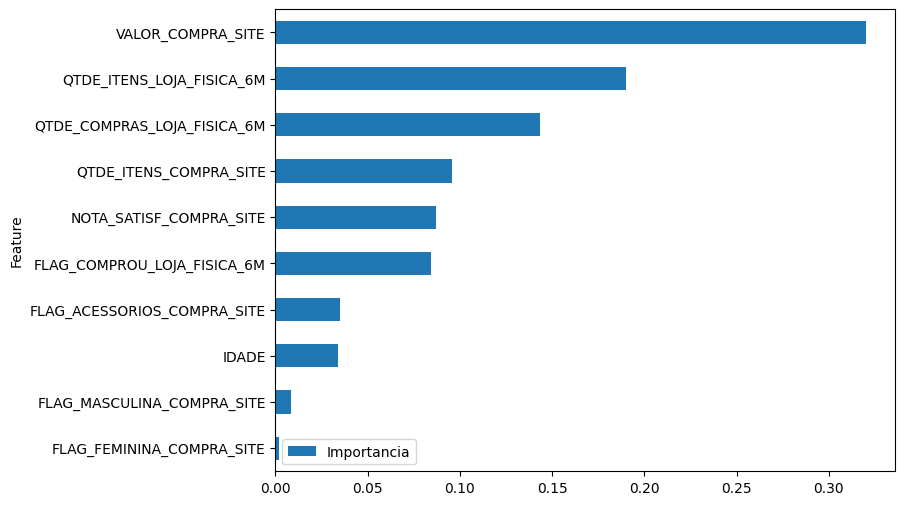

In [ ]:
# Gráfico das importâncias de Gini
df_importancias = pd.DataFrame({'Feature': features, 'Importancia': importancias}).sort_values(by = 'Importancia', ascending = True)
df_importancias.plot.barh(x = 'Feature', y = 'Importancia', figsize = (8, 6))
plt.show()

In [ ]:
# Cálculo de valores SHAP para as observações
explainer = shap.Explainer(floresta_1)
valores_shap = explainer(X)

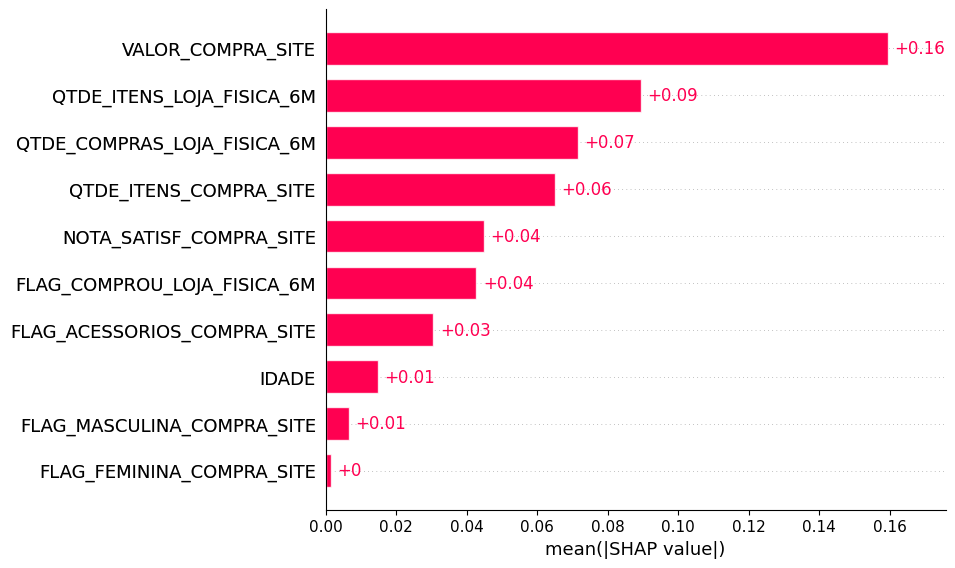

In [ ]:
# Gráfico do SHAP absoluto médio por feature
shap.plots.bar(valores_shap[:,:,0])

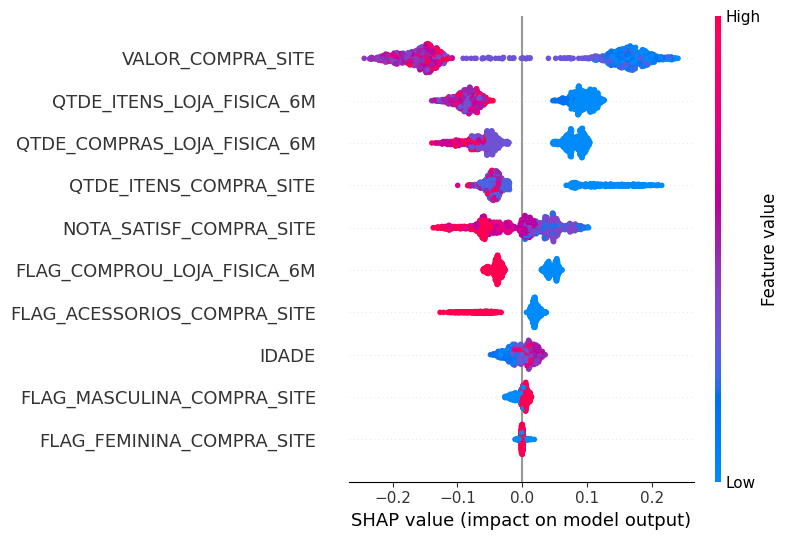

In [ ]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot)
shap.summary_plot(valores_shap[:,:,0])